In [1]:
cd ../

C:\Users\teruto\Desktop\sourcecode\livedoor-news-clustering


In [2]:
cd data

C:\Users\teruto\Desktop\sourcecode\livedoor-news-clustering\data


In [3]:
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
from copy import deepcopy

In [4]:
#ファイル読み込み
train_df = pd.read_csv('./preprosessing_train.csv')
X_df_train = train_df[['text_length', 'is_year', 'is_month', 'is_date',
       'is_time', 'num_hatena', 'num_bikkuri', 'is_eiga', 'is_henkakko',
       'is_normalkakko', 'is_whitekakko', 'is_vol', 'is_sports',
       'text_del_one']]
Y_df_train = train_df["flg"].astype(np.int64)
X_train =  X_df_train.values
t_train = Y_df_train.values

dev_df = pd.read_csv('./preprosessing_dev.csv')
X_df_dev = dev_df[['text_length', 'is_year', 'is_month', 'is_date',
       'is_time', 'num_hatena', 'num_bikkuri', 'is_eiga', 'is_henkakko',
       'is_normalkakko', 'is_whitekakko', 'is_vol', 'is_sports',
       'text_del_one']]
Y_df_dev = dev_df["flg"].astype(np.int64)
X_valid =  X_df_dev.values
t_valid = Y_df_dev.values

test_df = pd.read_csv('./preprosessing_test.csv')
X_df_test = test_df[['text_length', 'is_year', 'is_month', 'is_date',
       'is_time', 'num_hatena', 'num_bikkuri', 'is_eiga', 'is_henkakko',
       'is_normalkakko', 'is_whitekakko', 'is_vol', 'is_sports',
       'text_del_one']]
Y_df_test = test_df["flg"].astype(np.int64)
X_test =  X_df_test.values
t_test = Y_df_test.values

In [5]:
#特徴量配列
X_train_feat = X_train[:,:-1]
X_valid_feat = X_valid[:,:-1]
X_test_feat = X_test[:,:-1]
X_train_feat.shape


(5000, 13)

In [6]:
#特徴量標準化
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
ss = MinMaxScaler()
X_train_feat_ss = ss.fit_transform(X_train_feat)
X_valid_feat_ss = ss.transform(X_valid_feat)
X_test_feat_ss = ss.transform(X_test_feat)

In [7]:
#文字カラムに対する欠損値削除
X_train_del_one = X_train[:,-1]
for idx in range(len(X_train_del_one)):
    if type(X_train_del_one[idx]) is float:
        X_train_del_one[idx] = " " 

X_valid_del_one = X_valid[:,-1]
for idx in range(len(X_valid_del_one)):
    if type(X_valid_del_one[idx]) is float:
        X_valid_del_one[idx] = " "
        
X_test_del_one = X_test[:,-1]
for idx in range(len(X_test_del_one)):
    if type(X_test_del_one[idx]) is float:
        X_test_del_one[idx] = " "

In [8]:
#単語ベクトル化(最大値、最小値を設定した)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
cv = TfidfVectorizer(min_df=3/5000, max_df=3000/5000)
#cv = TfidfVectorizer()
X_train_cv = cv.fit_transform(X_train_del_one)
X_valid_cv = cv.transform(X_valid_del_one)
X_test_cv = cv.transform(X_test_del_one)

In [9]:
#文字配列と特徴量の配列を結合する
X_train = np.concatenate([X_train_cv.toarray(),X_train_feat_ss],1)
X_valid = np.concatenate([X_valid_cv.toarray(),X_valid_feat_ss],1)
X_test = np.concatenate([X_test_cv.toarray(),X_test_feat_ss],1)

In [10]:
#型変換
X_train = X_train.astype(np.float32)
X_valid = X_valid.astype(np.float32)
X_test = X_test.astype(np.float32)
t_train = t_train.astype(np.int32)
t_valid = t_valid.astype(np.int32)
t_test = t_test.astype(np.int32)

In [11]:

#スパース配列に変換
from scipy.sparse import csr_matrix
X_train_csr = csr_matrix(X_train)
X_valid_csr = csr_matrix(X_valid)
X_test_csr = csr_matrix(X_test)

In [12]:
#混合行列
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score ,precision_score, recall_score,f1_score
import seaborn as sns
def result_heatmap(Y_test,Y_pred):
    print("正解率:"+str(accuracy_score(Y_test, Y_pred)))
    cm = confusion_matrix(Y_test, Y_pred)
    #print(cm)
    sns.heatmap(cm,annot=True, cmap='Blues')

In [13]:
#PCA
from sklearn.decomposition import  TruncatedSVD 
pca =  TruncatedSVD(400)
X_train_pca = pca.fit_transform(X_train_csr) 
X_valid_pca = pca.transform(X_valid_csr)
X_test_pca = pca.transform(X_test_csr)

In [14]:
#models
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [51]:


class S1Model():
    def __init__(self,name):
        self.models = []
        self.name = name

        
    def fit_proba(self,X_train,y_train,X_valid):
        model = self.get_classifier(self.name)
        model.fit(X_train,y_train)
        self.models.append(model)
        return model.predict_proba(X_valid)
    
    def predict(self,X_test):  
        ave_arr = np.zeros((len(X_test),9))
        for model in self.models:
            proba = model.predict_proba(X_test)
            np.add(ave_arr,proba)
            proba = model.predict_proba(X_test_pca)
            ave_arr = np.add(ave_arr,proba)
        return ave_arr/len(self.models)
    
    def get_classifier(self,name):
        if name == "svm1":
            return svm.SVC(kernel="rbf",gamma = 0.01,C=50,probability=True)
        elif name == "svm2":
            return svm.SVC(kernel="linear",gamma = 10,C=10,probability=True)
        elif name == "rfc1":
            return RandomForestClassifier(n_estimators=100,max_depth = 3,criterion="entropy")
        elif name == "rfc2":
            return RandomForestClassifier(n_estimators=500,max_depth = 5,criterion= "gini")
        elif name == "mlp":
            return MLPClassifier(hidden_layer_sizes=(256,128,64,32),activation="relu",solver = "adam",max_iter=10000,early_stopping=True)
        elif name == "lr":
            return LogisticRegression(C=300,random_state=1)
        elif name == "gbc":
            return GradientBoostingClassifier(random_state=0)
        elif name == "abc":
            return AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=0), n_estimators=100, learning_rate=1,  random_state=None)
        elif name == "k-nei1":
            return  KNeighborsClassifier(n_neighbors=5)
        elif name == "k-nei2":
            return  KNeighborsClassifier(n_neighbors=20)
        

In [52]:
from sklearn.model_selection import StratifiedKFold
from copy import deepcopy

S1_models = [S1Model("svm1"),S1Model("svm2"),S1Model("rfc1"),S1Model("rfc2"),S1Model("mlp"),S1Model("lr"),S1Model("k-nei1"),S1Model("k-nei2"),S1Model("gbc"),S1Model("abc")]

X_valids = np.zeros((1,9*len(S1_models)))#9はラベルの種類
y_valids = np.zeros(1)

skf = StratifiedKFold(n_splits=5)#ここのランダム大事よ
for train_idx, valid_idx in skf.split(X_train_pca,t_train):
    print("new_epoc")
    X_train = X_train_pca[train_idx]
    y_train = t_train[train_idx]
    X_valid = X_train_pca[valid_idx]
    y_valid = t_train[valid_idx]
    temp_X_valids = np.zeros((np.shape(X_valid)[0],1))
    for model in S1_models:
        proba = model.fit_proba(X_train,y_train,X_valid)
        temp_X_valids = np.concatenate([temp_X_valids,proba],1)
        print(model.name+"done")
    #結合
    X_valids = np.concatenate([X_valids,temp_X_valids[:,1:len(temp_X_valids)]],0)
    y_valids = np.append(y_valids, y_valid)
X_valids = X_valids[1:np.shape(X_valids)[0],:]
y_valids = y_valids[1:len(y_valids)]

new_epoc
svm1done
svm2done
rfc1done
rfc2done
mlpdone


c:\users\teruto\desktop\sourcecode\livedoor-news-clustering\venv\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


lrdone
k-nei1done
k-nei2done
gbcdone
abcdone
new_epoc
svm1done
svm2done
rfc1done
rfc2done
mlpdone


c:\users\teruto\desktop\sourcecode\livedoor-news-clustering\venv\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


lrdone
k-nei1done
k-nei2done
gbcdone
abcdone
new_epoc
svm1done
svm2done
rfc1done
rfc2done
mlpdone


c:\users\teruto\desktop\sourcecode\livedoor-news-clustering\venv\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


lrdone
k-nei1done
k-nei2done
gbcdone
abcdone
new_epoc
svm1done
svm2done
rfc1done
rfc2done
mlpdone


c:\users\teruto\desktop\sourcecode\livedoor-news-clustering\venv\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


lrdone
k-nei1done
k-nei2done
gbcdone
abcdone
new_epoc
svm1done
svm2done
rfc1done
rfc2done
mlpdone


c:\users\teruto\desktop\sourcecode\livedoor-news-clustering\venv\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


lrdone
k-nei1done
k-nei2done
gbcdone
abcdone


In [53]:
np.savetxt('ensemble_kfold_X.txt', X_valids)
np.savetxt('ensemble_kfold_y.txt', y_valids)

In [54]:
np.shape(y_valids)

(5000,)

In [55]:
S2_model =MLPClassifier(hidden_layer_sizes=(256,128,64,32),activation="relu",solver = "adam",max_iter=10000,early_stopping=True)
S2_model.fit(X_valids,y_valids)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(256, 128, 64, 32), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=10000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [56]:
len(X_test_pca)

500

In [57]:

X_S2_test = np.zeros((np.shape(X_test_pca)[0],1)) 
for S1_model in S1_models:
    proba = S1_model.predict(X_test_pca)
    print(S1_model.name)
    X_S2_test = np.concatenate([X_S2_test,proba],1)
X_S2_test= X_S2_test[:,1:len(X_S2_test)]

svm1
svm2
rfc1
rfc2
mlp
lr
k-nei1
k-nei2
gbc
abc


In [58]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score ,precision_score, recall_score,f1_score
import seaborn as sns
def result_heatmap(Y_test,Y_pred):
    print("正解率:"+str(accuracy_score(Y_test, Y_pred)))
    cm = confusion_matrix(Y_test, Y_pred)
    print(cm)
    sns.heatmap(cm,annot=True, cmap='Blues')

正解率:0.78
[[51  0  0  2  0  1  3  4  0]
 [ 0 49  1  0  0  1  9  2  2]
 [ 0  3 40  5  0  0  0  0  7]
 [ 0  1  3 61  0  0  3  1  3]
 [ 1  1  0  5 20  0  6  3  0]
 [ 1  0  0  0  0 52  0  5  0]
 [ 0  6  1  5  0  1 37  2  0]
 [ 0  2  0  1  0  0  3 48  1]
 [ 0  5  5  3  0  0  2  0 32]]


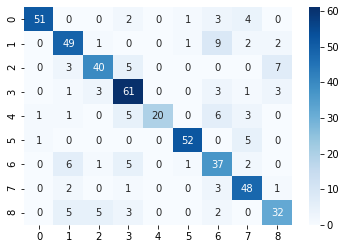

In [59]:
t_S2_pred = S2_model.predict(X_S2_test)
result_heatmap(t_test,t_S2_pred)